In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import math
import argparse

import hydra
from omegaconf import OmegaConf
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from tensordict.nn.probabilistic import InteractionType
from torchrl.envs import ParallelEnv, SerialEnv, TransformedEnv
from torchrl.record import VideoRecorder
from torchrl.modules.tensordict_module.exploration import AdditiveGaussianWrapper
from torchrl.objectives.dreamer import DreamerActorLoss, DreamerValueLoss
from torchrl.trainers.helpers.collectors import SyncDataCollector, MultiaSyncDataCollector
from torchrl.data.replay_buffers import TensorDictReplayBuffer, LazyMemmapStorage
from torchrl.trainers.trainers import Recorder

from causal_meta.helpers.envs import make_dreamer_env, create_make_env_list, build_make_env_list
from causal_meta.helpers.models import make_causal_dreamer
from causal_meta.helpers.logger import build_logger
from causal_meta.objectives.causal_dreamer import CausalDreamerModelLoss

from utils import grad_norm, match_length


In [3]:
path = "~/Projects/causal-meta/outputs/dreamer/test"
path = os.path.expanduser(path)

In [4]:
cfg_path = os.path.join(path, ".hydra", "config.yaml")
cfg = OmegaConf.load(cfg_path)
cfg

{'overrides': {'env_name': 'MyCartPole-v0', 'termination_fns': 'cartpole', 'reward_fns': '', 'env_max_steps': 200, 'train_frames_per_task': 2000, 'init_frames_per_task': 50, 'eval_interval_frames_per_task': 200, 'meta_test_interval_frames_per_task': 400, 'planning_horizon': 15, 'sparse_weight': 0.05, 'context_sparse_weight': 0.02, 'context_max_weight': 0.1, 'oracle_context': {'cart_vel_bias': [-0.5, 0.5], 'pole_vel_bias': [-0.5, 0.5]}, 'new_oracle_context': {'gravity': [5.0, 20.0]}}, 'env_name': '${overrides.env_name}', 'termination_fns': '${overrides.termination_fns}', 'reward_fns': '${overrides.reward_fns}', 'env_max_steps': '${overrides.env_max_steps}', 'train_frames_per_task': 500000, 'frames_per_batch': 800, 'init_frames_per_task': 0, 'batch_size': 50, 'batch_length': 25, 'train_agent_frames': 0, 'optim_steps_per_batch': 80, 'buffer_size': 20000, 'world_model_lr': 0.0006, 'actor_value_lr': 8e-05, 'context_lr': 0.1, 'observed_logits_lr': 0.01, 'context_logits_lr': 0.002, 'record_vi

In [5]:
if torch.cuda.is_available():
    device = torch.device(cfg.model_device)
else:
    device = torch.device("cpu")
print(f"Using device {device}")

Using device cpu


In [6]:
make_env_fn = partial(
    make_dreamer_env,
    variable_num=cfg.variable_num,
    state_dim_per_variable=cfg.state_dim_per_variable,
    hidden_dim_per_variable=cfg.belief_dim_per_variable
)
train_oracle_context = torch.load(os.path.join(path, "train_oracle_context.pt"), map_location=device)
test_oracle_context = torch.load(os.path.join(path, "test_oracle_context.pt"), map_location=device)
train_make_env_list = build_make_env_list(cfg.env_name, make_env_fn, train_oracle_context)
test_make_env_list = build_make_env_list(cfg.env_name, make_env_fn, test_oracle_context)

In [7]:
task_num = len(train_make_env_list)
proof_env = train_make_env_list[0]()
world_model, model_based_env, actor_model, value_model, policy = make_causal_dreamer(
    cfg=cfg,
    proof_environment=proof_env,
    device=device,
)

load_frame = sorted(map(int, os.listdir(os.path.join(path, "checkpoints"))))[-1]
world_model.load_state_dict(
    torch.load(os.path.join(path, "checkpoints", str(load_frame), f"world_model.pt"), map_location=device))
actor_model.load_state_dict(
    torch.load(os.path.join(path, "checkpoints", str(load_frame), f"actor_model.pt"), map_location=device))
value_model.load_state_dict(
    torch.load(os.path.join(path, "checkpoints", str(load_frame), f"value_model.pt"), map_location=device))

/Users/frank/opt/anaconda3/envs/tdfa/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [8]:
def to_image(pixel):
    pixel = (255 * (pixel + 0.5)).clamp(min=0, max=255).to(torch.uint8).permute(1, 2, 0).numpy()
    img = Image.fromarray(pixel)
    return img

In [9]:
td = proof_env.rollout(200)
td

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        belief: Tensor(shape=torch.Size([6, 200]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                belief: Tensor(shape=torch.Size([6, 200]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([6, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.Size([6, 3, 64, 64]), device=cpu, dtyp

In [10]:
td = world_model(td)
td

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        belief: Tensor(shape=torch.Size([6, 200]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                belief: Tensor(shape=torch.Size([6, 200]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                encoded_latents: Tensor(shape=torch.Size([6, 1024]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([6, 4]), device=cpu, 

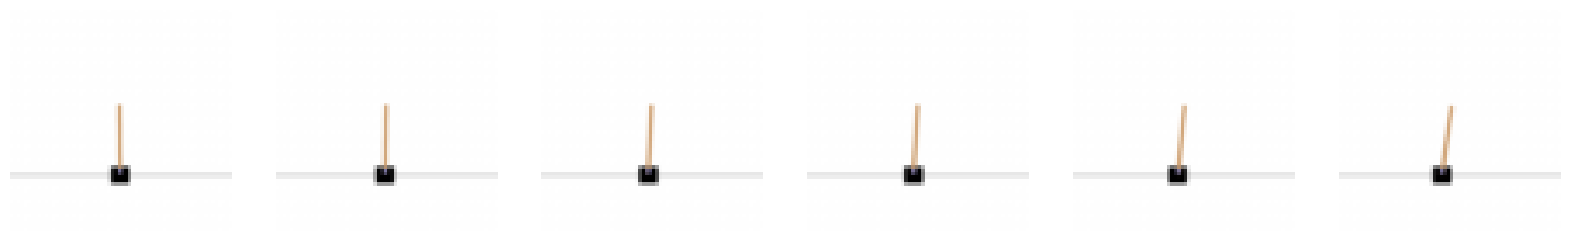

In [11]:
fig, axes = plt.subplots(1, td.shape[0], figsize=(20, 20 * td.shape[0]))
for i, ax in enumerate(axes):
    img = to_image(td[("next", "pixels")][i])
    ax.imshow(img)
    ax.axis("off")
plt.show()

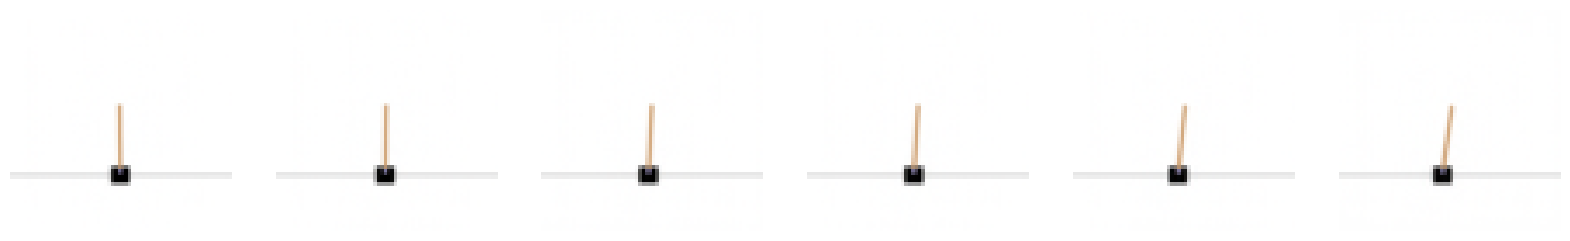

In [12]:
fig, axes = plt.subplots(1, td.shape[0], figsize=(20, 20 * td.shape[0]))
for i, ax in enumerate(axes):
    img = to_image(td[("next", "reco_pixels")][i])
    ax.imshow(img)
    ax.axis("off")
plt.show()

/var/folders/l4/t60nnw292zs2pd9xcnk9qqth0000gn/T/ipykernel_60671/2568713085.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
/var/folders/l4/t60nnw292zs2pd9xcnk9qqth0000gn/T/ipykernel_60671/2568713085.py:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
100%|██████████| 30/30 [00:00<00:00, 282.11it/s]


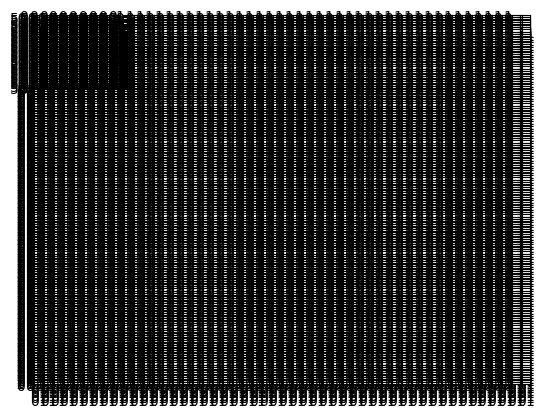

In [13]:
num = 10
state, belief = td[("next", "state")][0], td[("next", "belief")][0]
all_state = torch.zeros((state.shape[0], num, state.shape[0]))
all_belief = torch.zeros((state.shape[0], num, belief.shape[0]))
for i in range(len(state)):
    for j in range(num):
        state_ = state.clone()
        state_[i] = (j - num) / num
        all_state[i, j] = state_
        all_belief[i, j] = belief

all_pixel = world_model.obs_decoder(all_state, all_belief)
fig, axes = plt.subplots(5 * len(state), 5 * num, constrained_layout=True)
# plt.subplots_adjust(wspace=0, hspace=0)  
fig.tight_layout()
for i in tqdm(range(len(state))):
    for j in range(num):
        img = to_image(all_pixel[i, j])
        axes[i, j].imshow(img)
        # axes[i, j].axis("off")
plt.savefig("test.png")